In [133]:
#import pandas, matplotlib, seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [134]:
#read in and preview file
#download path https://www.kaggle.com/toshimelonhead/400000-kickstarter-projects
file_path = 'kickstarter.csv'

data = pd.read_csv(file_path, index_col = 'Unnamed: 0')
print(data.head(1))
data.info()

          id  backers_count  \
0  857125548              1   

                                               blurb currency    goal  \
0  Exploring paint and its place in a digital world.      USD  2000.0   

           launched_at             deadline location.country   name  \
0  2015-03-19 22:34:57  2015-04-30 23:12:00               US  Remix   

   usd_pledged  ... days_to_deadline  goal_USD  category_name  category_slug  \
0         25.0  ...               42    2000.0    Digital Art            art   

  blurb_length  location_type  location_country  location_state  \
0            9           Town                US              NY   

   location_displayable_name  binary_state  
0               New York, NY        failed  

[1 rows x 29 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 430938 entries, 0 to 768
Data columns (total 29 columns):
id                           430938 non-null int64
backers_count                430938 non-null int64
blurb                       

In [135]:
#is ID an appropriate index?
data.id.nunique()

316466

ID is not appropriate index as I believe because there are many duplicate transactions that probably result from changes

In [150]:
#Figure out what to do with duplicate IDs

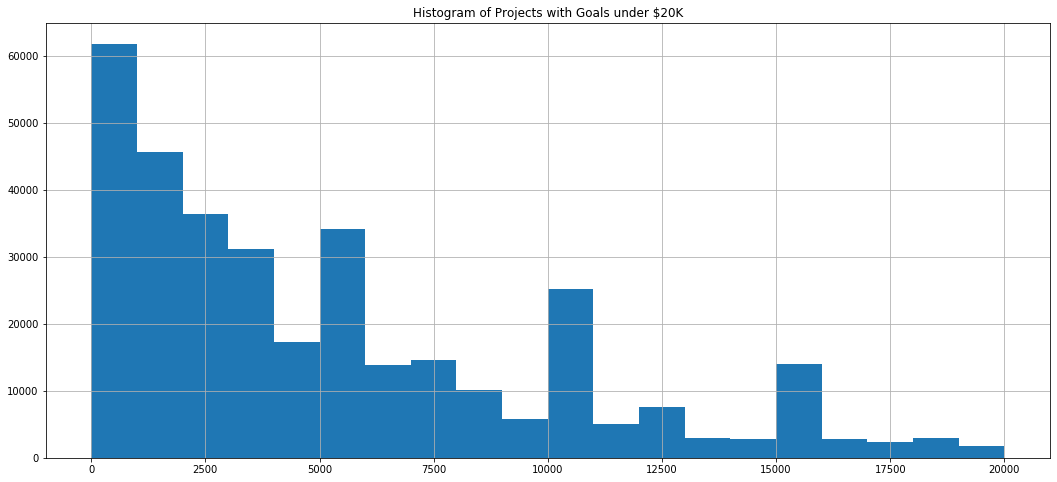

In [136]:
#attempt to understand goal_USD data shape by only looking at data under 20k (too zoomed out without the restriction)
data['goal_USD'].loc[data['goal_USD'] < 20000].hist(bins = 20, figsize=(18,8))
plt.title('Histogram of Projects with Goals under $20K')
plt.show()

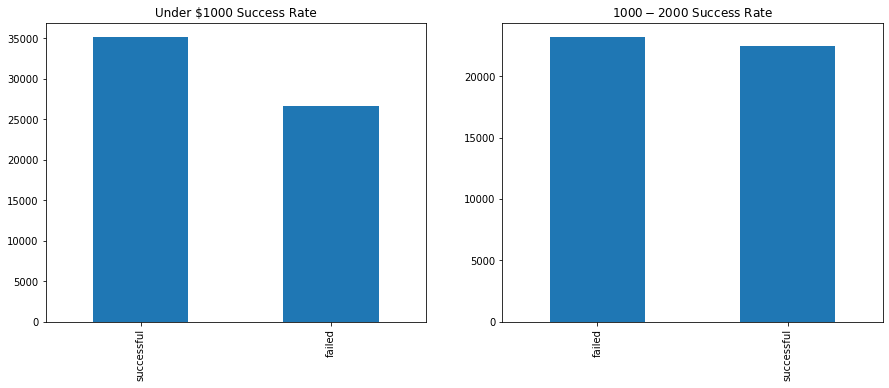

In [137]:
#Checking first 1000 category against 2nd 1000. Already by the second, failure is more likely than success.
fig=plt.figure(figsize=(15,5.5))
plt.subplot(1,2,1)
plt.title('Under $1000 Success Rate')
data['binary_state'].loc[data['goal_USD'] < 1000].value_counts().plot(kind='bar')
plt.subplot(1,2,2)
plt.title("$1000 - $2000 Success Rate")
data['binary_state'][(data['goal_USD'] >= 1000) & (data['goal_USD'] < 2000)].value_counts().plot(kind='bar')
plt.show()


I decided to throw out data with a goal under $1000 as they do not seem to be "serious" crowdfunding projects.

In [138]:
#throwing data with a goal under 1000
cleaned_data = data.loc[data['goal_USD'] >= 1000]

In [139]:
#print out approximate time when data was captured
print(cleaned_data['launched_at'].max())
#filter out data where target date is beyond the date of the data
cleaned_data = cleaned_data.loc[cleaned_data['deadline'] <= cleaned_data['launched_at'].max()]

2019-04-18 04:49:38


I threw out data where the deadline is beyond the cutoff date

In [140]:
#dropping the location.country column (there is already a location_country column); the days to deadline column as it is not useful for analysis as the deadline should be passed;
# the state column is not necessary with the binary state column; and the individual date columns are not necessary
cleaned_data = cleaned_data.drop(columns=['location.country', 'days_to_deadline', 'state', 'year', 'month', 'day', 'hour'])

I threw out some unnecessary columns.

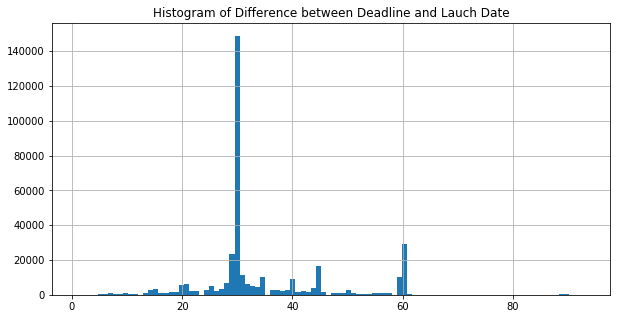

In [141]:
#create a new column for days between launch and goal date
cleaned_data['launched_at'] = pd.to_datetime(cleaned_data['launched_at'])
cleaned_data['deadline'] = pd.to_datetime(cleaned_data['deadline'])
#creating a histogram of Days Between
cleaned_data['days_between'] = (cleaned_data['deadline'] - cleaned_data['launched_at']).dt.days
cleaned_data['days_between'].hist(bins = 100, figsize = (10, 5))
plt.title('Histogram of Difference between Deadline and Lauch Date')
plt.show()

Most Kickstarters have the deadline set at around 30 days from the launch date. There are no extreme outliers (or they have been filtered out).

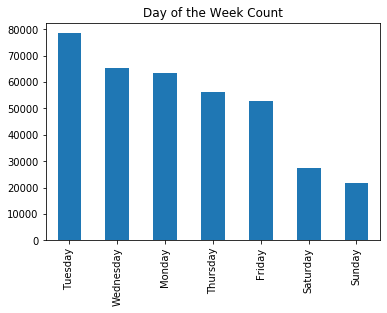

In [142]:
cleaned_data['day_week'] = cleaned_data['launched_at'].dt.day_name()
cleaned_data['day_week'].value_counts().plot(kind='bar')
plt.title('Day of the Week Count')
plt.show()

The middle of the week is the most popular launch time.

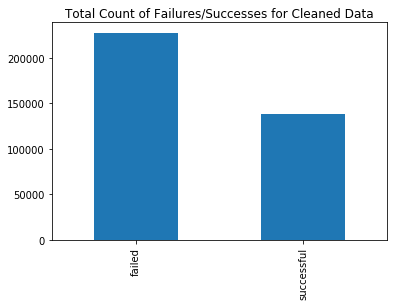

In [143]:
#create a bar chart of binary_state column
cleaned_data['binary_state'].value_counts().plot(kind='bar')
plt.title('Total Count of Failures/Successes for Cleaned Data')
plt.show()

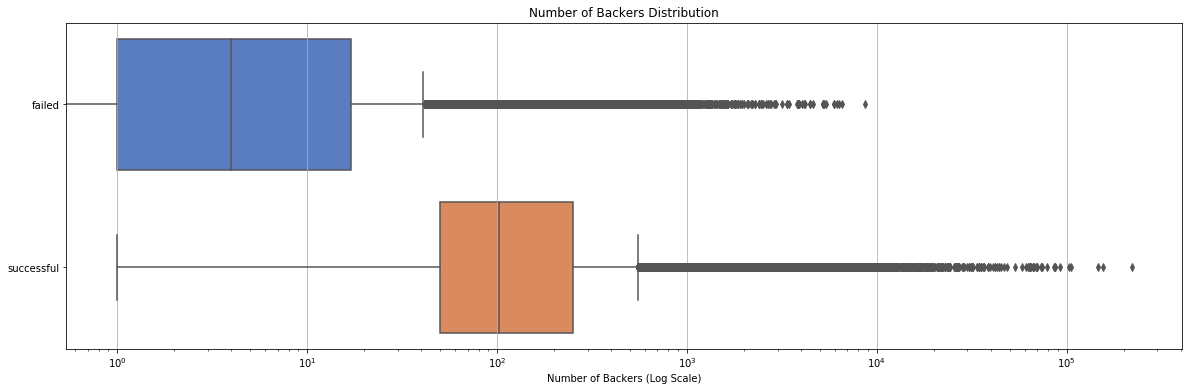

In [144]:
#looking distribution of the backers_count column
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="backers_count", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Number of Backers (Log Scale)", title = 'Number of Backers Distribution')
plt.show()

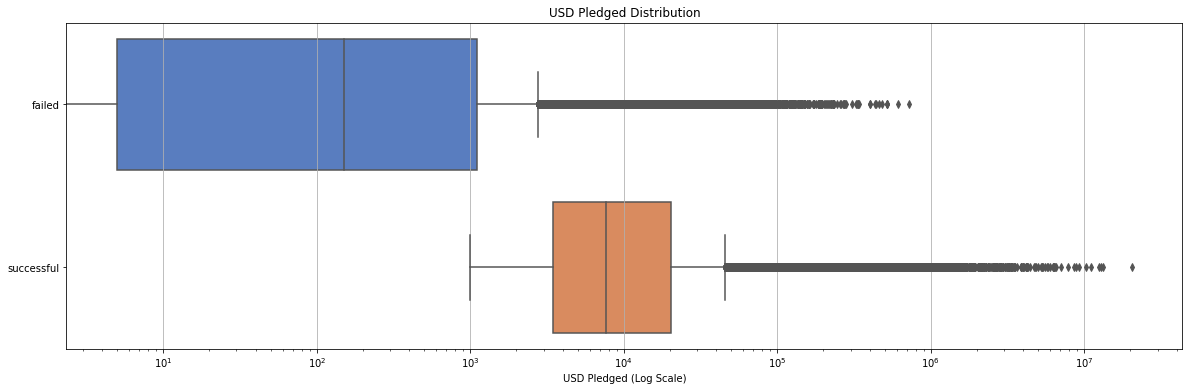

In [145]:
#looking at distribution of USD Pledged
#looking distribution of the backers_count column
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="usd_pledged", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "USD Pledged (Log Scale)", title = 'USD Pledged Distribution')
plt.show()

Successful Kickstarter campaigns are outliers in themselves

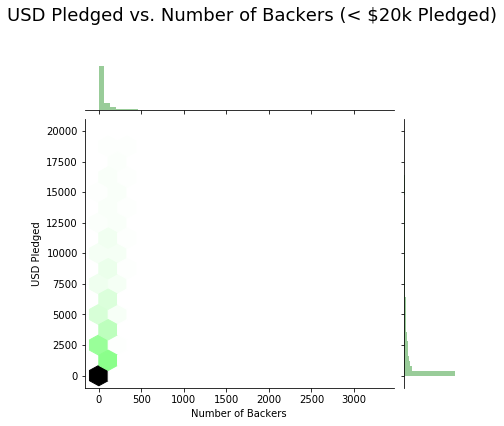

In [146]:
#practice hex binning data for visualization

x = cleaned_data['backers_count'].loc[cleaned_data['usd_pledged'] < 20000]
y = cleaned_data['usd_pledged'].loc[cleaned_data['usd_pledged'] < 20000]

joint_kws=dict(gridsize=15)

fig = sns.jointplot(x, y, kind ="hex",  
                    color ="green", joint_kws= joint_kws) 
  
fig.fig.subplots_adjust(top = 0.85) 

fig.set_axis_labels('Number of Backers',  
                    'USD Pledged') 
  
fig.fig.suptitle('USD Pledged vs. Number of Backers (< $20k Pledged)',  
                 size = 18); 

plt.show()



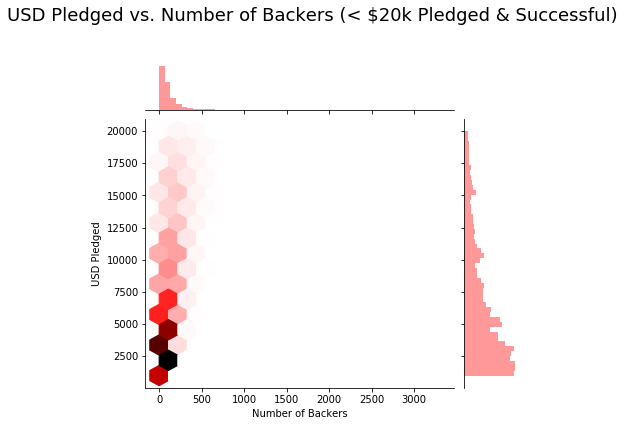

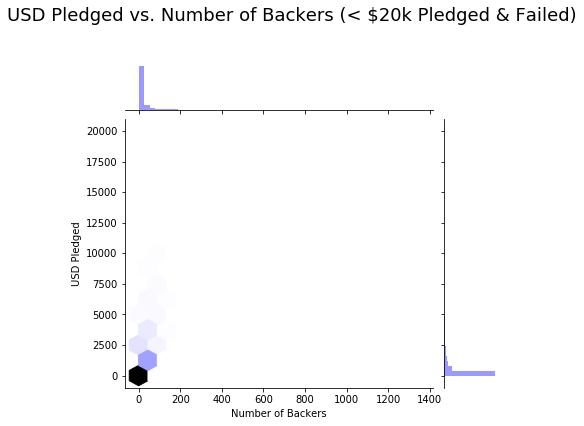

In [147]:
#Successful kickstarter projects

x = cleaned_data['backers_count'].loc[(cleaned_data['usd_pledged'] < 20000) & (cleaned_data['binary_state'] == 'successful')]
y = cleaned_data['usd_pledged'].loc[(cleaned_data['usd_pledged'] < 20000) & (cleaned_data['binary_state'] == 'successful')]

joint_kws=dict(gridsize=15)

fig = sns.jointplot(x, y, kind ="hex",  
                    color ="red", joint_kws= joint_kws) 
  
fig.fig.subplots_adjust(top = 0.85) 

fig.set_axis_labels('Number of Backers',  
                    'USD Pledged') 
  
fig.fig.suptitle('USD Pledged vs. Number of Backers (< $20k Pledged & Successful)',  
                 size = 18); 
plt.show()

#Unsuccessful

x = cleaned_data['backers_count'].loc[(cleaned_data['usd_pledged'] < 20000) & (cleaned_data['binary_state'] == 'failed')]
y = cleaned_data['usd_pledged'].loc[(cleaned_data['usd_pledged'] < 20000) & (cleaned_data['binary_state'] == 'failed')]

joint_kws=dict(gridsize=15)

fig = sns.jointplot(x, y, kind ="hex",  
                    color ="blue", joint_kws= joint_kws) 
  
fig.fig.subplots_adjust(top = 0.85) 

fig.set_axis_labels('Number of Backers',  
                    'USD Pledged') 
  
fig.fig.suptitle('USD Pledged vs. Number of Backers (< $20k Pledged & Failed)',  
                 size = 18); 

plt.show()

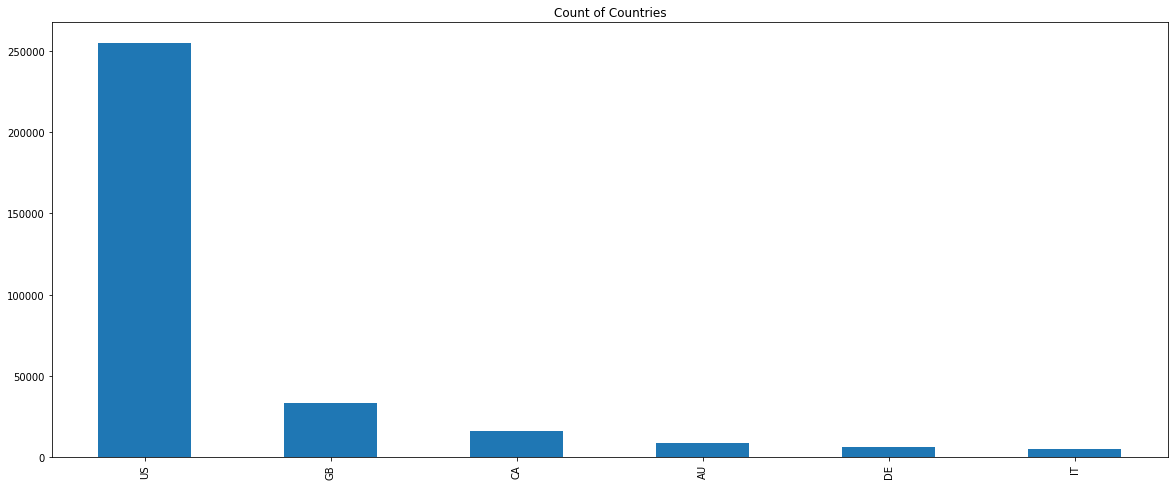

In [148]:
#show the frequency of location country for those with at least 5000 occurrences
cleaned_data['location_country'].value_counts()[cleaned_data['location_country'].value_counts()>5000].plot(kind='bar',
                                    figsize=(20,8),
                                    title="Count of Countries")
plt.show()


There are only six countries with more than 5000 occurrences. The US dominates with Great Britain and Canada coming in second and third.

In [149]:
cleaned_data.info()
cleaned_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365236 entries, 0 to 541
Data columns (total 24 columns):
id                           365236 non-null int64
backers_count                365236 non-null int64
blurb                        365236 non-null object
currency                     365236 non-null object
goal                         365236 non-null float64
launched_at                  365236 non-null datetime64[ns]
deadline                     365236 non-null datetime64[ns]
name                         365232 non-null object
usd_pledged                  365236 non-null float64
slug                         365236 non-null object
spotlight                    365236 non-null bool
staff_pick                   365236 non-null bool
static_usd_rate              365236 non-null float64
goal_USD                     365236 non-null float64
category_name                365236 non-null object
category_slug                365236 non-null object
blurb_length                 365236 non-null i

,id,backers_count,blurb,currency,goal,launched_at,deadline,name,usd_pledged,slug,...,category_name,category_slug,blurb_length,location_type,location_country,location_state,location_displayable_name,binary_state,days_between,day_week
0,857125548,1,Exploring paint and its place in a digital world.,USD,2000.0,2015-03-19 22:34:57,2015-04-30 23:12:00,Remix,25.00000,remix,...,Digital Art,art,9,Town,US,NY,"New York, NY",failed,42,Thursday
4,1260075071,1,I want to bring colour to the world in my own ...,GBP,15000.0,2015-02-06 21:52:02,2015-03-08 20:52:02,North Africa art project - my dream,1.52011,north-africa-art-project-my-dream,...,Digital Art,art,26,County,GB,England,"Essex, UK",failed,29,Friday
6,1653837117,2,Help me raise money to get a drawing tablet,USD,2900.0,2015-04-06 16:09:42,2015-05-16 16:09:42,I love Drawing,40.00000,i-love-drawing,...,Digital Art,art,9,Town,US,CA,"San Diego, CA",failed,40,Monday
7,1049918057,1,I would like to share my art with the world an...,USD,5000.0,2015-01-25 01:40:38,2015-03-26 00:40:38,SolNigma Art Prints and Apparel,50.00000,solnigma-art-prints,...,Digital Art,art,23,Town,US,NY,"Cazenovia, NY",failed,59,Sunday
8,1450790277,0,Post Card donâ€™t set out to simply decorate s...,GBP,2000.0,2015-08-13 01:17:58,2015-10-02 01:17:58,The Hong Kong Eye Mini Art,0.00000,the-hong-kong-eye-mini-art,...,Digital Art,art,22,Town,GB,England,"London, UK",failed,50,Thursday
